In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from tabulate import tabulate
from helpers.util_functions import normalise_value

from moral.ppo import PPO, TrajectoryDataset, update_policy
from envs.gym_wrapper import *
import random

from quality_metrics.validity_measures import validity_all as validity
from quality_metrics.validity_measures import validity_single, validity_single_partial
from quality_metrics.distance_measures import distance_all as distance
from quality_metrics.distance_measures import distance_single
from quality_metrics.diversity_measures import diversity_all as diversity
from quality_metrics.diversity_measures import diversity_single, distance_subtrajectories
from quality_metrics.critical_state_measures import critical_state_all as critical_state
from quality_metrics.critical_state_measures import critical_state_single
from quality_metrics.realisticness_measures import realisticness_all as realisticness
from quality_metrics.realisticness_measures import realisticness_single_partial
from quality_metrics.sparsity_measure import sparsity_all as sparsity
from quality_metrics.sparsity_measure import sparsitiy_single_partial

# pearson correlation
from scipy.stats import pearsonr, spearmanr

c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
class config:
    env_id= 'randomized_v2'
    env_steps= 8e6
    batchsize_ppo= 12
    n_queries= 50
    preference_noise= 0
    n_workers= 1
    lr_ppo= 3e-4
    entropy_reg= 0.25
    gamma= 0.999
    epsilon= 0.1
    ppo_epochs= 5
    max_dacs = 75
    base_path = '.\datasets\\100mdac\\'
    measure_statistics = True
    num_runs = 30
    criteria = ['validity', 'diversity', 'proximity', 'critical_state', 'realisticness', 'sparsity']
    # criteria = ['baseline']
    # criteria = ['validity']
    cf_method = 'mcts' # 'mcts' or 'dac'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [84]:
# Load normalisation

with open('..\..\interpretability\\normalisation_values.pkl', 'rb') as f:
    normalisation = pkl.load(f)

weights = pkl.load(open('..\..\quality_metrics\\1000weights.pkl', 'rb'))

random.seed(4)
seed_env = random.randint(0, 100000)
torch.manual_seed(seed_env)
np.random.seed(seed_env)

# Create Environment
vec_env = VecEnv(config.env_id, config.n_workers, seed=seed_env)
states = vec_env.reset()
states_tensor = torch.tensor(states).float().to(device)

# Fetch Shapes
n_actions = vec_env.action_space.n
obs_shape = vec_env.observation_space.shape
state_shape = obs_shape[:-1]
in_channels = obs_shape[-1]

ppo = PPO(state_shape=state_shape, in_channels=in_channels, n_actions=n_actions).to(device)
ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10].pt', map_location=torch.device('cpu')))
# ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10]_new.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
def load_data(folder):
    try:
        with open('..\..\\' + folder + '\cf_trajectories.pkl', 'rb') as f:
            cfs = pkl.load(f)
        with open('..\..\\' + folder + '\org_trajectories.pkl', 'rb') as f:
            orgs = pkl.load(f)
        with open('..\..\\' + folder + '\statistics\start_points.pkl', 'rb') as f:
            starts = pkl.load(f)
        # with open('..\..\\' + folder + '\statistics\lengths_cf.pkl', 'rb') as f:
        #     lengths = pkl.load(f)
        # with open('..\..\\' + folder + '\statistics\effiencies.pkl', 'rb') as f:
        #     efficiencies = pkl.load(f)
    except:
        # delete the folder
        print(folder)
        return None, None, None
    return orgs, cfs, starts

In [5]:
folder_random = 'datasets\\ablations_norm\\1000\\random'
folder_mcts = 'datasets\\ablations_norm\\1000\\mcts'
folder_dac = 'datasets\\ablations_norm\\1000\\dac'

orgs_random, cfs_random, starts_random = load_data(folder_random)
orgs_mcts, cfs_mcts, starts_mcts = load_data(folder_mcts)
orgs_dac, cfs_dac, starts_dac = load_data(folder_dac)

print(len(orgs_random), len(orgs_mcts), len(orgs_dac))

1000 1000 1000


# afdsfd

In [6]:
def measure_qc(orgs, cfs, starts, apply_weights=True):
    vals, proxs, divs, crits, spars, reals, qcs = [], [], [], [], [], [], []
    prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []
    for i in range(len(orgs)):
        weight = weights[i]
        val = validity_single_partial(orgs[i][0], cfs[i][0])
        if apply_weights:
            val = normalise_value(val, normalisation, 'validity') * weight['validity']
        else:
            val = normalise_value(val, normalisation, 'validity')
        vals.append(val)
        prox = distance_subtrajectories(orgs[i][0], cfs[i][0])
        if apply_weights:
            prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
        else:
            prox = normalise_value(prox, normalisation, 'proximity')
        proxs.append(prox)
        div = diversity_single(orgs[i][0], cfs[i][0], starts[i], prev_org_trajs, prev_cf_trajs, prev_starts)
        if apply_weights:
            div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
        else:
            div = normalise_value(div, normalisation, 'diversity')
        divs.append(div)
        crit = critical_state_single(ppo, orgs[i][0]['states'][0])
        if apply_weights:
            crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
        else:
            crit = normalise_value(crit, normalisation, 'critical_state')
        crits.append(crit)
        length = len(orgs[i][0]['rewards']) + len(cfs[i][0]['rewards'])
        spar = sparsitiy_single_partial(orgs[i][0], cfs[i][0])
        if apply_weights:
            spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
        else:
            spar = normalise_value(spar, normalisation, 'sparsity')
        spars.append(spar)
        real = realisticness_single_partial(orgs[i][0], cfs[i][0])
        if apply_weights:
            real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
        else:
            real = normalise_value(real, normalisation, 'realisticness')
        reals.append(real)
        if apply_weights:
            qc = val + prox + div + crit + spar + real
        else:
            qc = val*weight['validity'] + prox*weight['proximity'] + div*weight['diversity'] + crit*weight['critical_state'] + spar*weight['sparsity'] + real*weight['realisticness']
        qcs.append(qc)

        prev_org_trajs.append(orgs[i][0])
        prev_cf_trajs.append(cfs[i][0])
        prev_starts.append(starts[i])
    return vals, proxs, divs, crits, spars, reals, qcs

In [7]:
vals_random, proxs_random, divs_random, crits_random, spars_random, reals_random, qcs_random = measure_qc(orgs_random, cfs_random, starts_random, apply_weights=False)
vals_mcts, proxs_mcts, divs_mcts, crits_mcts, spars_mcts, reals_mcts, qcs_mcts = measure_qc(orgs_mcts, cfs_mcts, starts_mcts, apply_weights=False)
vals_dac, proxs_dac, divs_dac, crits_dac, spars_dac, reals_dac, qcs_dac = measure_qc(orgs_dac, cfs_dac, starts_dac, apply_weights=False)

In [8]:
random_means = [np.mean(vals_random), np.mean(proxs_random), np.mean(divs_random), np.mean(crits_random), np.mean(reals_random), np.mean(spars_random), np.mean(qcs_random)]
random_medians = [np.median(vals_random), np.median(proxs_random), np.median(divs_random), np.median(crits_random), np.median(reals_random), np.median(spars_random), np.median(qcs_random)]
random_upper_quartile = [np.quantile(vals_random, 0.75), np.quantile(proxs_random, 0.75), np.quantile(divs_random, 0.75), np.quantile(crits_random, 0.75), np.quantile(reals_random, 0.75), np.quantile(spars_random, 0.75), np.quantile(qcs_random, 0.75)]
random_lower_quartile = [np.quantile(vals_random, 0.25), np.quantile(proxs_random, 0.25), np.quantile(divs_random, 0.25), np.quantile(crits_random, 0.25), np.quantile(reals_random, 0.25), np.quantile(spars_random, 0.25), np.quantile(qcs_random, 0.25)]

mcts_means = [np.mean(vals_mcts), np.mean(proxs_mcts), np.mean(divs_mcts), np.mean(crits_mcts), np.mean(reals_mcts), np.mean(spars_mcts), np.mean(qcs_mcts)]
mcts_medians = [np.median(vals_mcts), np.median(proxs_mcts), np.median(divs_mcts), np.median(crits_mcts), np.median(reals_mcts), np.median(spars_mcts), np.median(qcs_mcts)]
mcts_upper_quartile = [np.quantile(vals_mcts, 0.75), np.quantile(proxs_mcts, 0.75), np.quantile(divs_mcts, 0.75), np.quantile(crits_mcts, 0.75), np.quantile(reals_mcts, 0.75), np.quantile(spars_mcts, 0.75), np.quantile(qcs_mcts, 0.75)]
mcts_lower_quartile = [np.quantile(vals_mcts, 0.25), np.quantile(proxs_mcts, 0.25), np.quantile(divs_mcts, 0.25), np.quantile(crits_mcts, 0.25), np.quantile(reals_mcts, 0.25), np.quantile(spars_mcts, 0.25), np.quantile(qcs_mcts, 0.25)]

dac_means = [np.mean(vals_dac), np.mean(proxs_dac), np.mean(divs_dac), np.mean(crits_dac), np.mean(reals_dac), np.mean(spars_dac), np.mean(qcs_dac)]
dac_medians = [np.median(vals_dac), np.median(proxs_dac), np.median(divs_dac), np.median(crits_dac), np.median(reals_dac), np.median(spars_dac), np.median(qcs_dac)]
dac_upper_quartile = [np.quantile(vals_dac, 0.75), np.quantile(proxs_dac, 0.75), np.quantile(divs_dac, 0.75), np.quantile(crits_dac, 0.75), np.quantile(reals_dac, 0.75), np.quantile(spars_dac, 0.75), np.quantile(qcs_dac, 0.75)]
dac_lower_quartile = [np.quantile(vals_dac, 0.25), np.quantile(proxs_dac, 0.25), np.quantile(divs_dac, 0.25), np.quantile(crits_dac, 0.25), np.quantile(reals_dac, 0.25), np.quantile(spars_dac, 0.25), np.quantile(qcs_dac, 0.25)]

[0.36030428651805657, 0.31461680331432973]
1.450836032694929


C:\Users\janwe\AppData\Local\Temp/ipykernel_17416/4161082880.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='major', color='#666666', linestyle='--', axis='y')


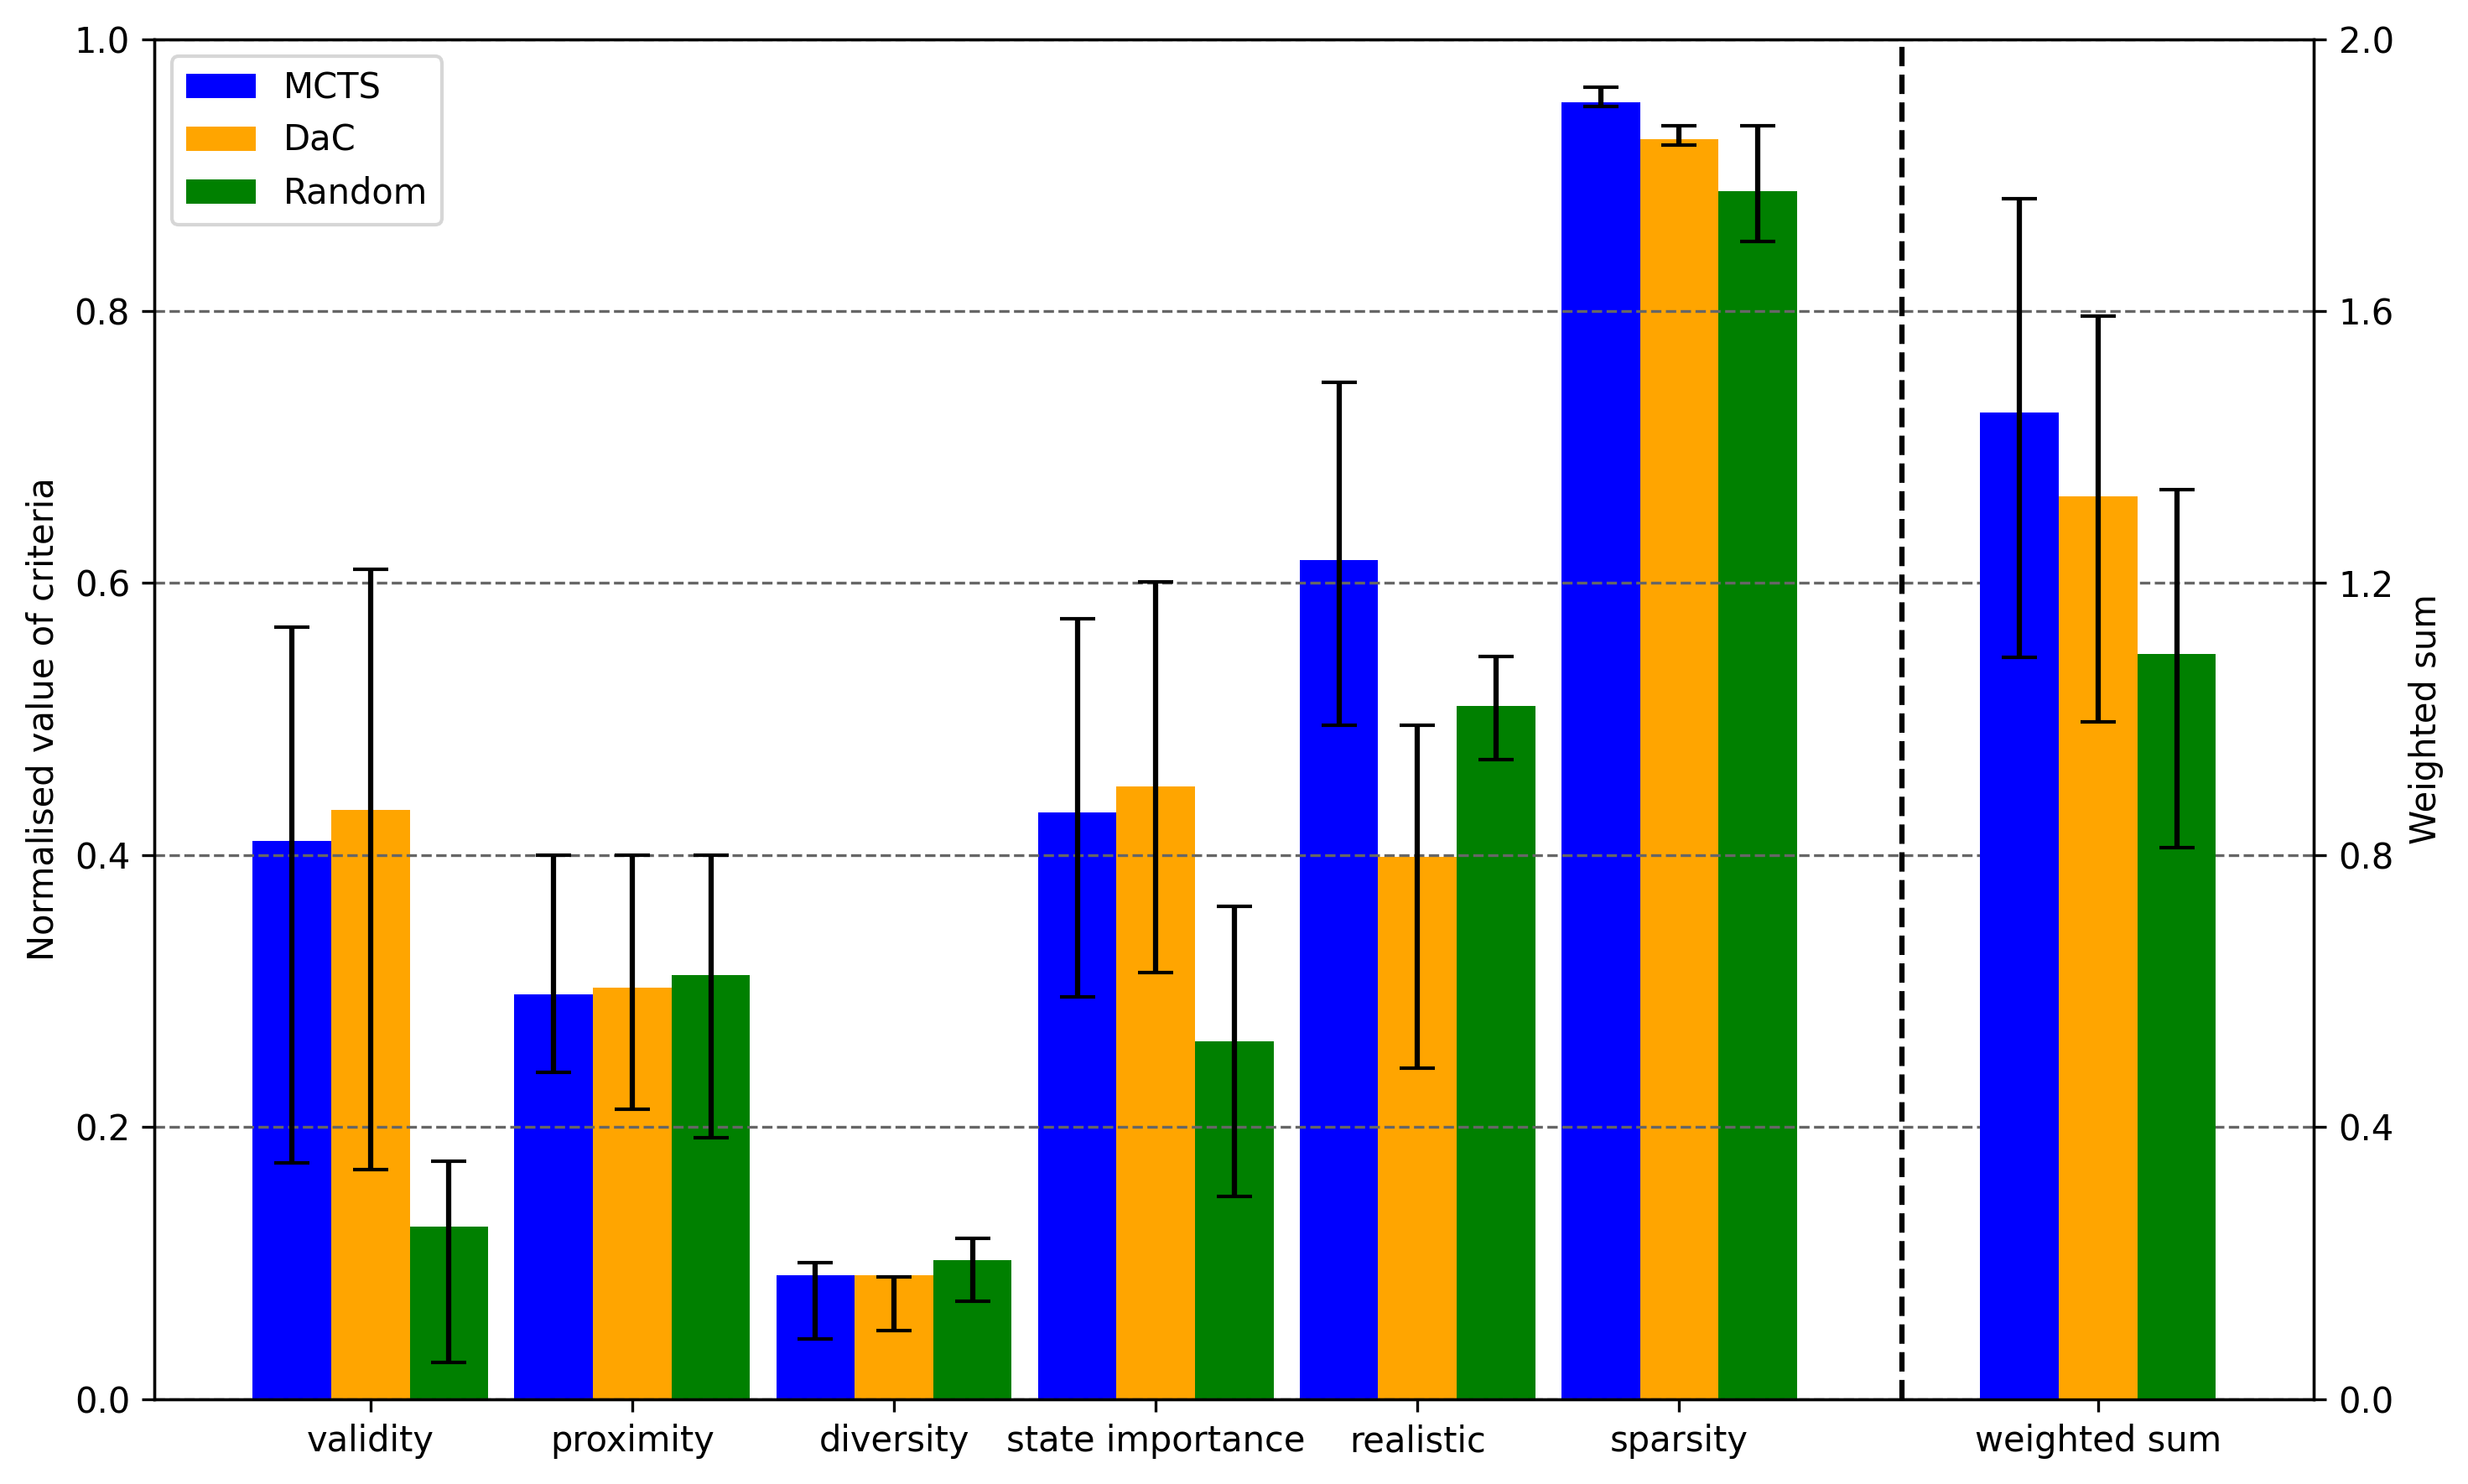

In [9]:
criteria = ['validity', 'proximity', 'diversity', 'state importance', 'realistic', 'sparsity', 'weighted_sum']

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
width = 0.3
ax2 = ax1.twinx()

x = np.arange(len(criteria))
x_qc = list(np.array(len(criteria) - 1 + np.array([width, 2*width, 3*width])))  # Create three points for QC

x = list(np.arange(len(criteria) - 1))
x_qc = list(np.array(len(criteria) - 1 + np.array([width, 2*width, 3*width])))  # Create three points for QC

rects1 = ax1.bar(np.array(x) - width, mcts_means[:-1], width, color='b', label='MCTS', yerr=[np.subtract(mcts_means[:-1], mcts_lower_quartile[:-1]), np.subtract(mcts_upper_quartile[:-1], mcts_means[:-1])], capsize=5)
rects2 = ax1.bar(x, dac_means[:-1], width, label='DaC', color='orange', yerr=[np.subtract(dac_means[:-1], dac_lower_quartile[:-1]), np.subtract(dac_upper_quartile[:-1], dac_means[:-1])], capsize=5)
rects3 = ax1.bar(np.array(x) + width, random_means[:-1], width, label='Random', color='g', yerr=[np.subtract(random_means[:-1], random_lower_quartile[:-1]), np.subtract(random_upper_quartile[:-1], random_means[:-1])], capsize=5)

yerrr = [np.subtract(mcts_means[-1], mcts_lower_quartile[-1]), np.subtract(mcts_upper_quartile[-1], mcts_means[-1])]
print(yerrr)
print(mcts_means[-1])
rects4 = ax2.bar(x_qc[0], mcts_means[-1], width, color='b', label='MCTS-QC', capsize=5, yerr=[[np.subtract(mcts_means[-1], mcts_lower_quartile[-1])], [np.subtract(mcts_upper_quartile[-1], mcts_means[-1])]])
rects5 = ax2.bar(x_qc[1], dac_means[-1], width, color='orange', label='DaC', capsize=5, yerr=[[np.subtract(dac_means[-1], dac_lower_quartile[-1])], [np.subtract(dac_upper_quartile[-1], dac_means[-1])]])
rects6 = ax2.bar(x_qc[2], random_means[-1], width, color='g', label='Random-QC', capsize=5, yerr=[[np.subtract(random_means[-1], random_lower_quartile[-1])], [np.subtract(random_upper_quartile[-1], random_means[-1])]])

ax1.axvline(x=x_qc[0] - 1.5*width, color='black', linestyle='--')
ax1.set_ylim([0,1.0])

ax1.set_ylabel('Normalised value of criteria', color='black')
ax1.set_xticks(x + [np.mean(x_qc)])  # We put the tick in the middle of the 3 'QC' bars
ax1.set_xticklabels(criteria[:-1]+['weighted sum'])
ax2.set_ylabel('Weighted sum', color='black')  # Assuming QC stands for quality control
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

fig.tight_layout()  # This will ensure that the labels and title don't overlap

# gridlines
# for y in np.arange(0, 1, 0.1):  # Replace min_value, max_value and dac_value by your actual values
#     ax1.hlines(y, xmin=-1.5, xmax=(x_qc[0] - 1.5*width), colors='#666666', linestyle='--')

ax1.grid(b=True, which='major', color='#666666', linestyle='--', axis='y')
ax2.grid(False)

ax2.set_ylim([0.0, 2.0])
ax2.set_yticks(np.arange(0.0, 2.1, 0.4))

plt.show()

C:\Users\janwe\AppData\Local\Temp/ipykernel_17416/3442746180.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='major', color='#666666', linestyle='--', axis='y')
C:\Users\janwe\AppData\Local\Temp/ipykernel_17416/3442746180.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('quality_criteria_NN.pdf', type='pdf')


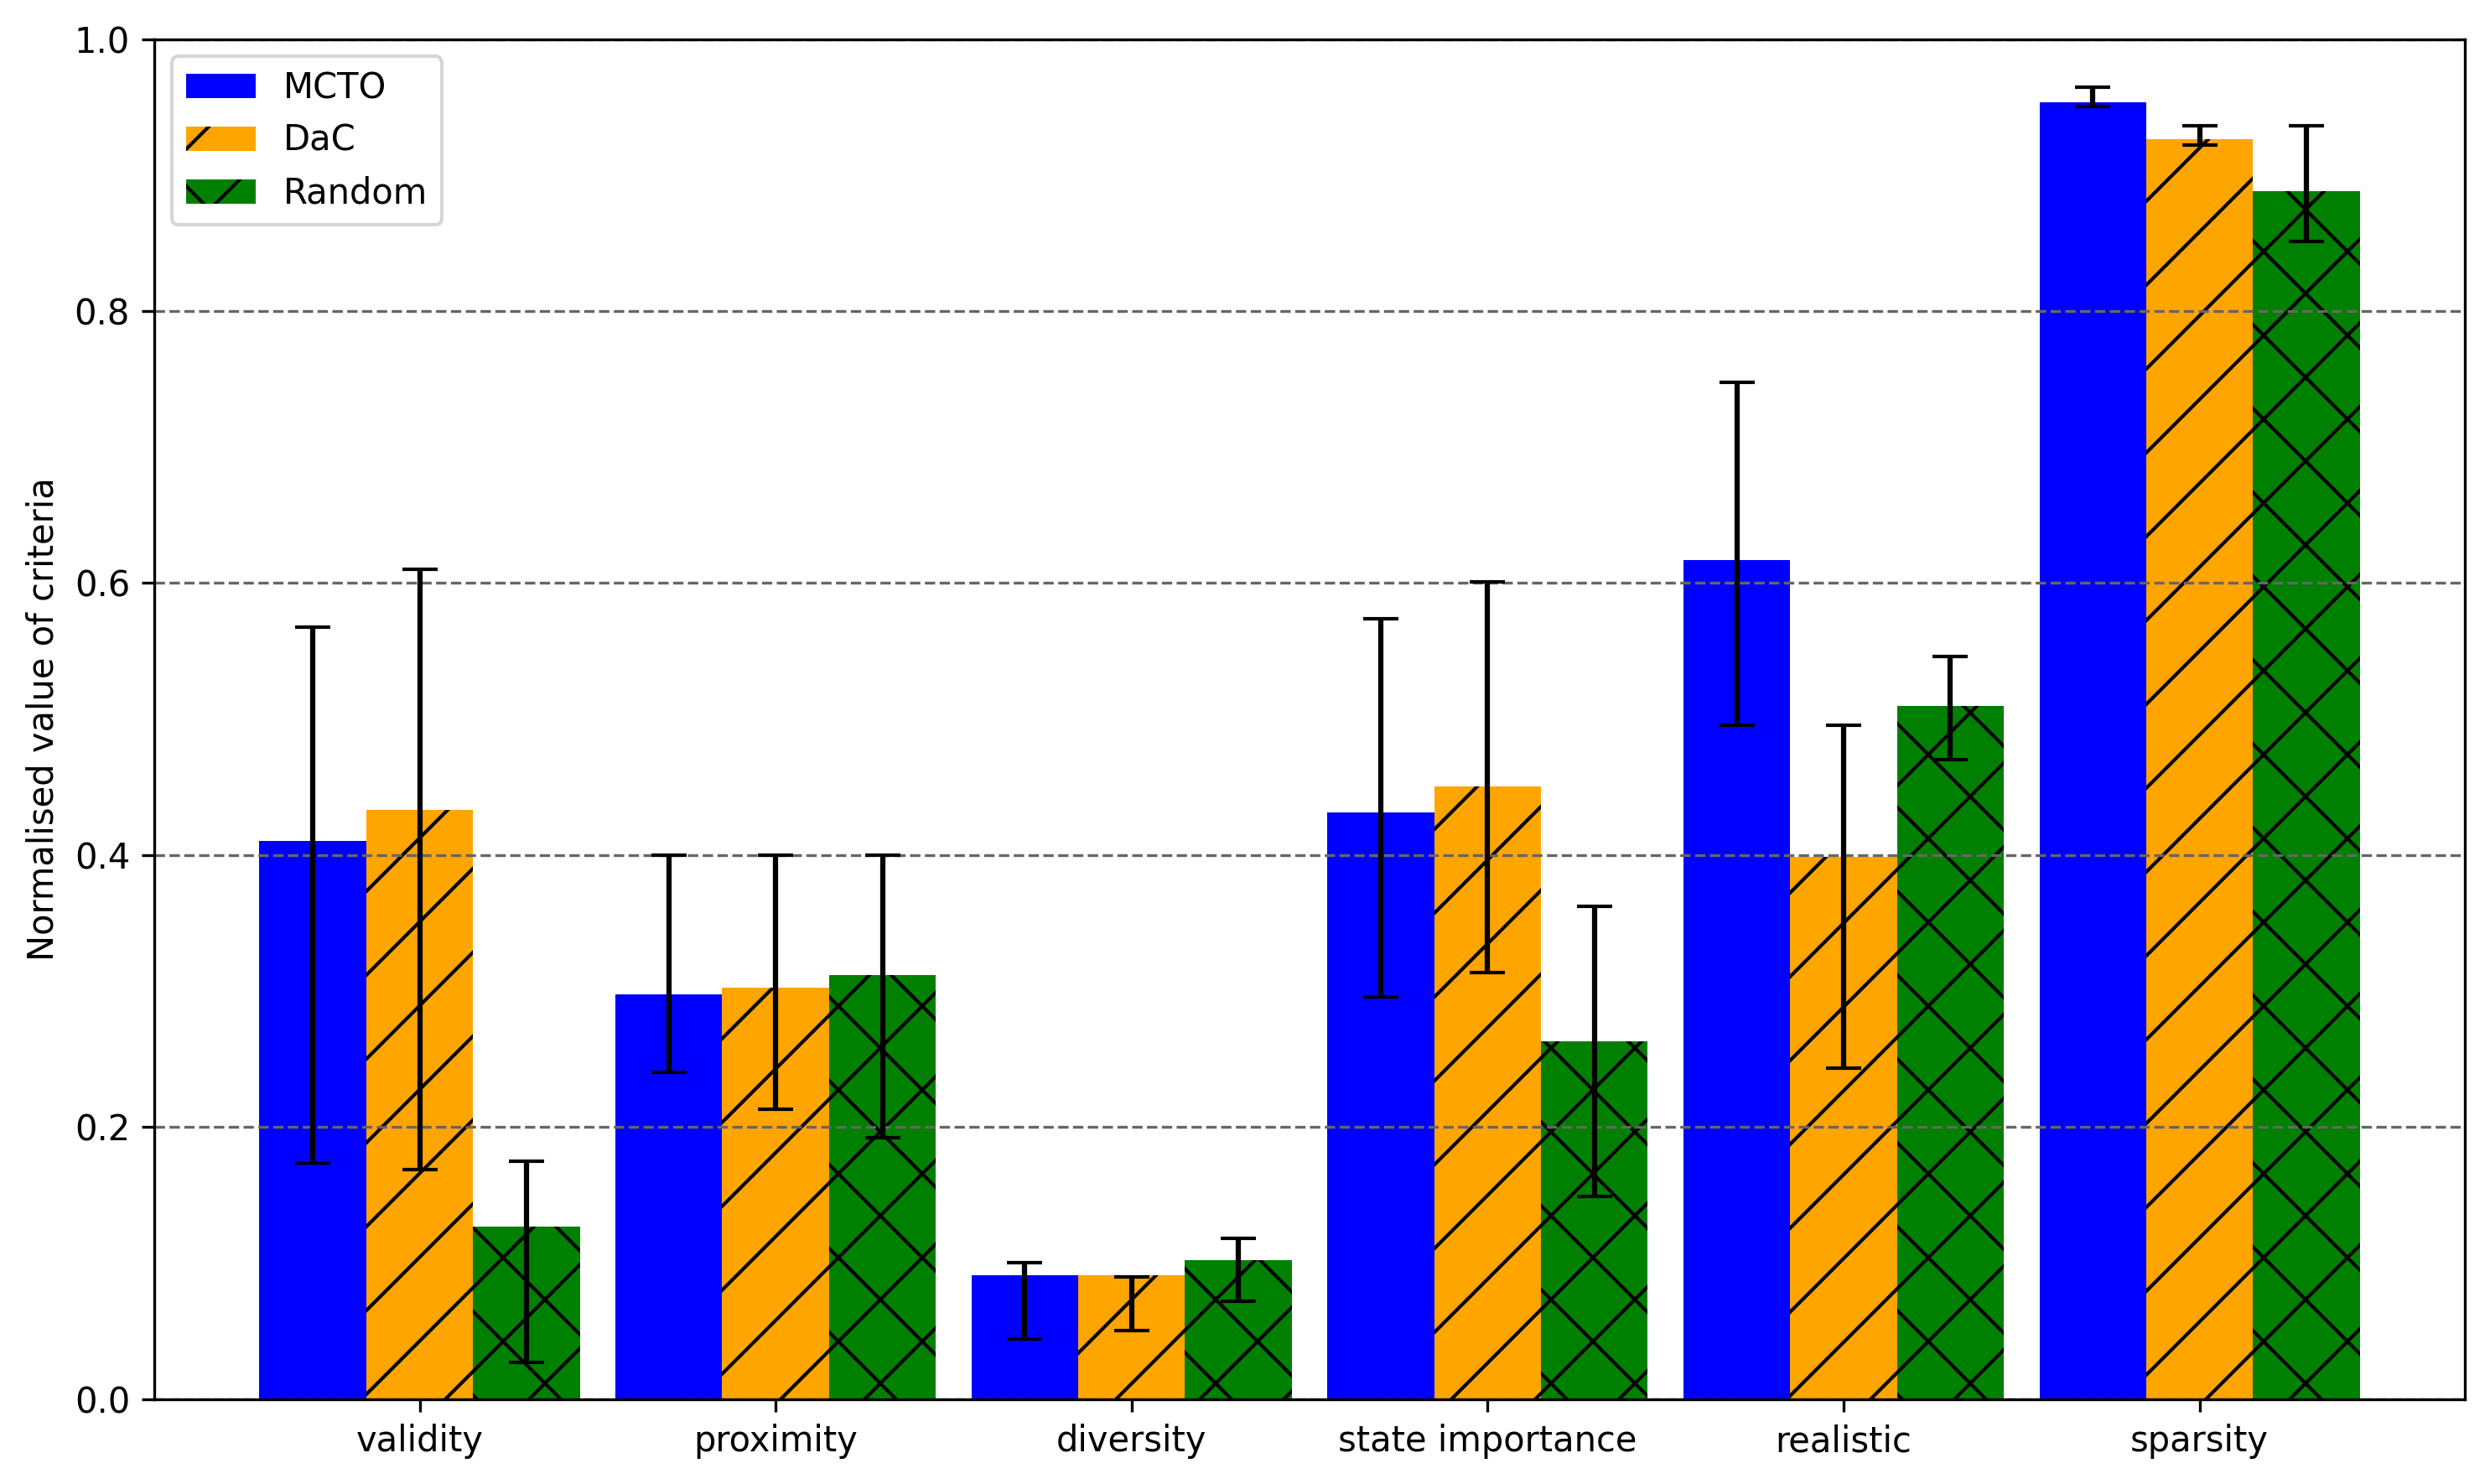

In [29]:
criteria = ['validity', 'proximity', 'diversity', 'state importance', 'realistic', 'sparsity']

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
width = 0.3

x = np.arange(len(criteria))
x_qc = list(np.array(len(criteria) - 1 + np.array([width, 2*width, 3*width])))  # Create three points for QC

rects1 = ax1.bar(np.array(x) - width, mcts_means[:-1], width, color='b', label='MCTO', yerr=[np.subtract(mcts_means[:-1], mcts_lower_quartile[:-1]), np.subtract(mcts_upper_quartile[:-1], mcts_means[:-1])], capsize=5)
rects2 = ax1.bar(x, dac_means[:-1], width, label='DaC', color='orange', yerr=[np.subtract(dac_means[:-1], dac_lower_quartile[:-1]), np.subtract(dac_upper_quartile[:-1], dac_means[:-1])], capsize=5, hatch='/')
rects3 = ax1.bar(np.array(x) + width, random_means[:-1], width, label='Random', color='g', yerr=[np.subtract(random_means[:-1], random_lower_quartile[:-1]), np.subtract(random_upper_quartile[:-1], random_means[:-1])], capsize=5, hatch='x')

ax1.set_ylabel('Normalised value of criteria', color='black')
ax1.set_xticks(x)  # We put the tick in the middle of the 3 'QC' bars
ax1.legend(loc='upper left')
ax1.set_ylim([0,1.0])
# ax2.legend(loc='upper right')

fig.tight_layout()  # This will ensure that the labels and title don't overlap

# gridlines
# for y in np.arange(0, 1, 0.1):  # Replace min_value, max_value and dac_value by your actual values
#     ax1.hlines(y, xmin=-1.5, xmax=(x_qc[0] - 1.5*width), colors='#666666', linestyle='--')
ax1.set_xticklabels(criteria)
ax1.grid(b=True, which='major', color='#666666', linestyle='--', axis='y')
ax2.grid(False)


plt.savefig('quality_criteria_NN.pdf', type='pdf')

C:\Users\janwe\AppData\Local\Temp/ipykernel_17416/797445040.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('quality_value_NN.pdf', type='pdf')


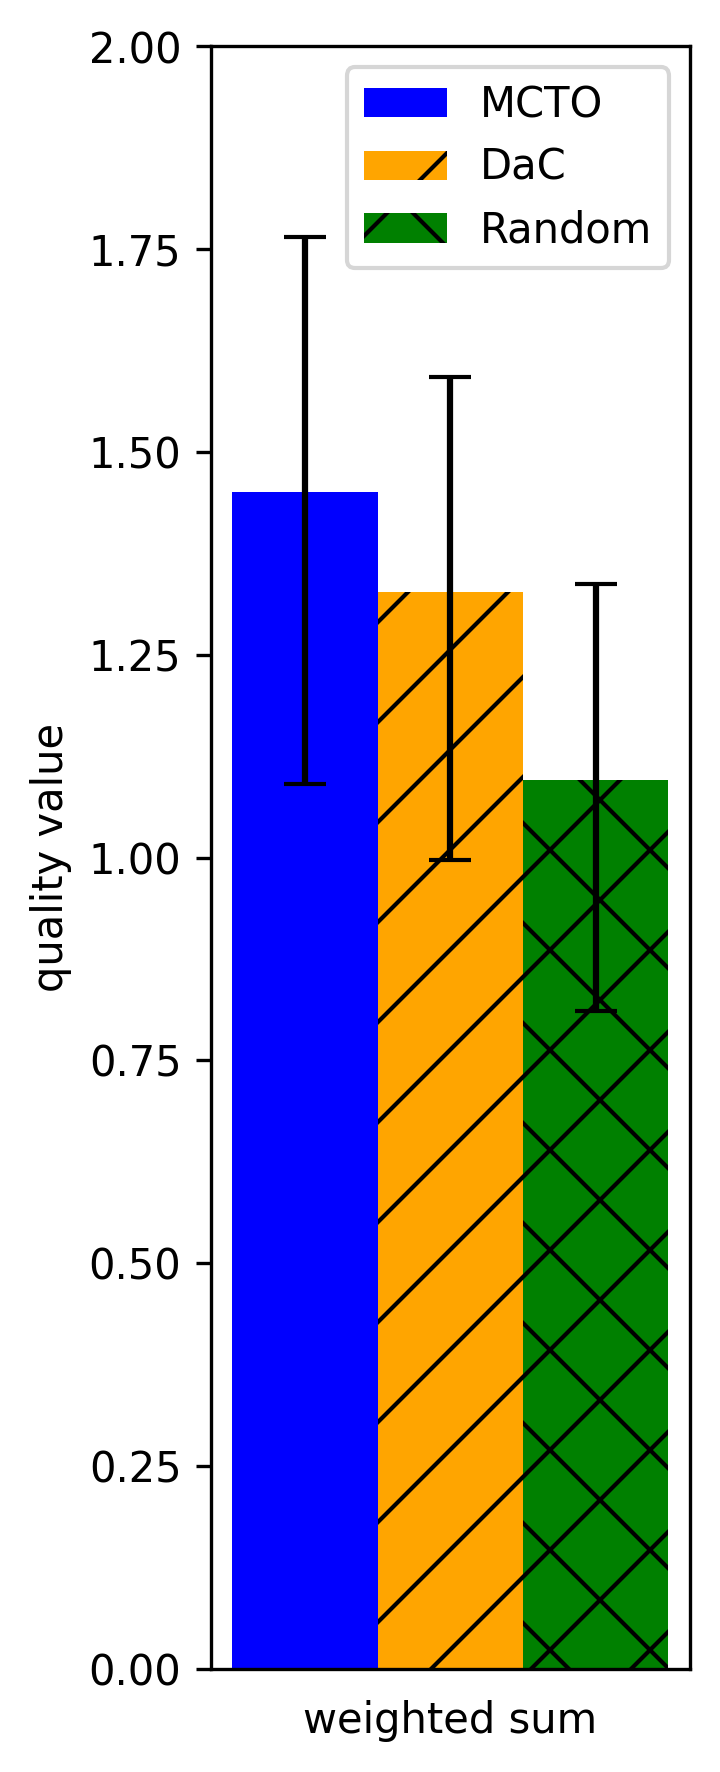

In [55]:
criteria = ['weighted sum']

fig, ax1 = plt.subplots(figsize=(2.5, 6), dpi=300)
width = 0.2

x = np.arange(len(criteria))

yerrr = [np.subtract(mcts_means[-1], mcts_lower_quartile[-1]), np.subtract(mcts_upper_quartile[-1], mcts_means[-1])]
rects4 = ax1.bar(x_qc[0], mcts_means[-1], width, color='b', label='MCTO', capsize=5, yerr=[[np.subtract(mcts_means[-1], mcts_lower_quartile[-1])], [np.subtract(mcts_upper_quartile[-1], mcts_means[-1])]])
rects5 = ax1.bar(x_qc[1], dac_means[-1], width, color='orange', label='DaC', capsize=5, yerr=[[np.subtract(dac_means[-1], dac_lower_quartile[-1])], [np.subtract(dac_upper_quartile[-1], dac_means[-1])]], hatch='/')
rects6 = ax1.bar(x_qc[2], random_means[-1], width, color='g', label='Random', capsize=5, yerr=[[np.subtract(random_means[-1], random_lower_quartile[-1])], [np.subtract(random_upper_quartile[-1], random_means[-1])]], hatch='x')

ax1.set_ylabel('quality value', color='black')  # We put the tick in the middle of the 3 'QC' bars
ax1.legend(loc='upper right')
ax1.set_ylim([0,2.0])
# ax2.legend(loc='upper right')

fig.tight_layout()  # This will ensure that the labels and title don't overlap

ax1.set_xticks(x)
ax1.set_xticklabels(criteria, rotation='vertical', va='top') 
ax1.set_xlabel('weighted sum') 

# gridlines
# for y in np.arange(0, 1, 0.1):  # Replace min_value, max_value and dac_value by your actual values
#     ax1.hlines(y, xmin=-1.5, xmax=(x_qc[0] - 1.5*width), colors='#666666', linestyle='--')
plt.savefig('quality_value_NN.pdf', type='pdf')

In [84]:
# test statistical significance of differences in qc
import scipy.stats as stats

print(np.mean(qcs_mcts), np.mean(qcs_dac), np.mean(qcs_random))
print(np.std(qcs_mcts), np.std(qcs_dac), np.std(qcs_random))

print(stats.ttest_ind(qcs_mcts, qcs_dac))
print(stats.ttest_ind(qcs_mcts, qcs_random))
print(stats.ttest_ind(qcs_dac, qcs_random))


1.441335489689355 1.319240707078533 1.095684272303309
0.5027365956511594 0.4894590110861141 0.386257378407392
Ttest_indResult(statistic=5.49994903611712, pvalue=4.286649845456091e-08)
Ttest_indResult(statistic=17.232204653081496, pvalue=3.7742489145178187e-62)
Ttest_indResult(statistic=11.332517628003195, pvalue=6.76153912503722e-29)


In [82]:
# load efficiency and lengths
with open('..\..\datasets\\ablations_norm\\best\\dac\statistics\lengths_cf.pkl', 'rb') as f:
    lengths_cf_dac = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\dac\statistics\lengths_org.pkl', 'rb') as f:
    lengths_org_dac = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\dac\statistics\effiencies.pkl', 'rb') as f:
    efficiencies_dac = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\dac\statistics\start_points.pkl', 'rb') as f:
    starts_dac = pkl.load(f)

with open('..\..\datasets\\ablations_norm\\best\\mcts\statistics\lengths_cf.pkl', 'rb') as f:
    lengths_cf_mcts = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\mcts\statistics\lengths_org.pkl', 'rb') as f:
    lengths_org_mcts = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\mcts\statistics\effiencies.pkl', 'rb') as f:
    efficiencies_mcts = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\mcts\statistics\start_points.pkl', 'rb') as f:
    starts_mcts = pkl.load(f)

with open('..\..\datasets\\ablations_norm\\best\\random\statistics\lengths_cf.pkl', 'rb') as f:
    lengths_cf_random = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\random\statistics\lengths_org.pkl', 'rb') as f:
    lengths_org_random = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\random\statistics\effiencies.pkl', 'rb') as f:
    efficiencies_random = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\random\statistics\start_points.pkl', 'rb') as f:
    starts_random = pkl.load(f)

In [83]:
table = [
    ['', 'MCTS', 'dac', 'Random'],
    ['Validity', round(np.mean(vals_mcts), 2), round(np.mean(vals_dac), 2), round(np.mean(vals_random), 2)],
    ['Proximity', round(np.mean(proxs_mcts), 2), round(np.mean(proxs_dac), 2), round(np.mean(proxs_random), 2)],
    ['Diversity', round(np.mean(divs_mcts), 2), round(np.mean(divs_dac), 2), round(np.mean(divs_random), 2)],
    ['Critical', round(np.mean(crits_mcts), 2), round(np.mean(crits_dac), 2), round(np.mean(crits_random), 2)],
    ['Realistic', round(np.mean(reals_mcts), 2), round(np.mean(reals_dac), 2), round(np.mean(reals_random), 2)],
    ['Sparsity', round(np.mean(spars_mcts), 2), round(np.mean(spars_dac), 2), round(np.mean(spars_random), 2)],
    ['QC', round(np.mean(qcs_mcts), 2), round(np.mean(qcs_dac), 2), round(np.mean(qcs_random), 2)],
    ['Efficiency', round(np.mean(efficiencies_mcts), 2), round(np.mean(efficiencies_dac), 2), round(np.mean(efficiencies_random), 2)],
    ['Length', round(np.mean(lengths_cf_mcts), 2), round(np.mean(lengths_cf_dac), 2), round(np.mean(lengths_cf_random), 2)],
    ['Starting Points', round(np.mean(starts_mcts), 2), round(np.mean(starts_dac), 2), round(np.mean(starts_random), 2)],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrrr}
\hline
                 &   MCTS &   dac &   Random \\
\hline
 Validity        &   0.41 &  0.43 &     0.13 \\
 Proximity       &   0.3  &  0.3  &     0.31 \\
 Diversity       &   0.08 &  0.08 &     0.1  \\
 Critical        &   0.43 &  0.45 &     0.26 \\
 Realistic       &   0.62 &  0.4  &     0.51 \\
 Sparsity        &   0.95 &  0.93 &     0.89 \\
 QC              &   1.44 &  1.32 &     1.1  \\
 Efficiency      &  14.86 &  5.46 &     0.04 \\
 Length          &   2.76 &  4.96 &     7.41 \\
 Starting Points &  20.96 & 20.45 &    42.58 \\
\hline
\end{tabular}


# Comparing informativeness

In [101]:
class NN_params:
    learning_rate = 0.03
    regularisation = 0.001
    num_layers = 5
    hidden_layer_sizes = [92, 92, 46]
    epochs = 15569

In [85]:
class LM_params:
    learning_rate = 0.1
    regularisation = 0.01
    epochs = 1893

In [86]:
# load weights
with open('..\..\quality_metrics\\1000weights.pkl', 'rb') as f:
    loaded_weights = pkl.load(f)

In [102]:
model_type = 'NN' # 'NN'

In [87]:
def load_nn_model(num_features, hidden_layer_sizes, num_layers, path, outputs):
    layers = [num_features*2] + hidden_layer_sizes + [outputs]
    base_model = torch.nn.Sequential()
    base_model.add_module('linear' + str(0), torch.nn.Linear(layers[0], layers[1]))
    for i in range(1, num_layers-2):
        base_model.add_module('relu' + str(i-1), torch.nn.ReLU())
        base_model.add_module('linear' + str(i), torch.nn.Linear(layers[i], layers[i+1]))
    base_model.add_module('relu' + str(num_layers-3), torch.nn.ReLU())
    model_end = torch.nn.Linear(layers[-2], layers[-1])

    model = torch.nn.Sequential(base_model, model_end)
    model.load_state_dict(torch.load(path))
    return model

In [88]:
def load_lm_model(num_features, outputs, path):
    model = torch.nn.Linear(num_features*2, outputs)
    model.load_state_dict(torch.load(path))
    return model

In [104]:
num_features = 46

# numbers from 0 to 29
weights = [i for i in range(1,10)]
methods = ['mcts', 'dac', 'random']

models_con = {}
models_sin = {}

# go through folders in 'datasets\weights\step'
for method in methods:
    models_con[method] = []
    models_sin[method] = []
    folder_path = '..\..\datasets\\ablations_norm\\best\\' + str(method) + '\\results\800\saved_models'
    for path in os.listdir(folder_path):
        if 'baseline' in path:
            continue
        if 'con' in path:
            if model_type == 'linear':
                model = load_lm_model(num_features, 1, os.path.join(folder_path, path))
            elif model_type == 'NN':
                model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 1)
            models_con[method].append(model)
        elif 'sin' in path:
            if model_type == 'linear':
                model = load_lm_model(num_features, 2, os.path.join(folder_path, path))
            elif model_type == 'NN':
                model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 2)
            models_sin[method].append(model)

In [105]:
# load the datasets
test_set_cons = {}
test_set_sins = {}
test_labels_cons = {}
test_labels_sins = {}

for method in methods:
    # datasets\weights\step\weight_1\data_split_con.pkl
    with open('..\..\datasets\\ablations_norm\\best\\' +str(method) +'\data_split_con.pkl', 'rb') as f:
        _, _, test_set_con, test_labels_con = pkl.load(f)
    with open('..\..\datasets\\ablations_norm\\best\\'+str(method)+'\data_split_sin.pkl', 'rb') as f:
        _, _, test_set_sin, test_labels_sin = pkl.load(f)

    test_set_cons[method] = test_set_con
    test_set_sins[method] = test_set_sin
    test_labels_cons[method] = test_labels_con
    test_labels_sins[method] = test_labels_sin

# load the whole test set
with open('..\..\datasets\\ablations_norm\\best\\baseline\data_split_con.pkl', 'rb') as f:
    _, _, test_set_con_combined, test_labels_con_combined = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\best\\baseline\data_split_sin.pkl', 'rb') as f:
    _, _, test_set_sin_combined, test_labels_sin_combined = pkl.load(f)

In [94]:
from evaluation.evaluate_mimic import evaluate_mimic, evaluate_mimic_binary

def test(models, test, labels):
    test_losses_random, test_mean_errors_random, test_rmses_random, r2s_random, pearson_correlations_random, spearman_correlations_random = [], [], [], [], [], []
    for model in models:
        test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, test, labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
        test_losses_random.append(test_loss)
        test_mean_errors_random.append(test_mean_error)
        test_rmses_random.append(test_rmse)
        r2s_random.append(r2)
        pearson_correlations_random.append(pearson_correlation)
        spearman_correlations_random.append(spearman_correlation)

    return test_losses_random, test_mean_errors_random, test_rmses_random, r2s_random, pearson_correlations_random, spearman_correlations_random

def test_binary(models, test, labels, contrastive=True):
    sign_accuracies = []
    for model in models:
        sign_accuracies.append(evaluate_mimic_binary(model, test, labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'], contrastive=contrastive))
    return sign_accuracies
    

In [106]:
test_losses_own_con, test_mean_errors_own_con, test_rmses_own_con, r2s_own_con, pearson_correlations_own_con, spearman_correlations_own_con = {}, {}, {}, {}, {}, {}
test_losses_combined_con, test_mean_errors_combined_con, test_rmses_combined_con, r2s_combined_con, pearson_correlations_combined_con, spearman_correlations_combined_con = {}, {}, {}, {}, {}, {}
test_losses_own_sin, test_mean_errors_own_sin, test_rmses_own_sin, r2s_own_sin, pearson_correlations_own_sin, spearman_correlations_own_sin = {}, {}, {}, {}, {}, {}
test_losses_combined_sin, test_mean_errors_combined_sin, test_rmses_combined_sin, r2s_combined_sin, pearson_correlations_combined_sin, spearman_correlations_combined_sin = {}, {}, {}, {}, {}, {}
pearson_correlations_combined_sincon = {}
for method in methods:
    test_losses_own_con[method], test_mean_errors_own_con[method], test_rmses_own_con[method], r2s_own_con[method], pearson_correlations_own_con[method], spearman_correlations_own_con[method] = test(models_con[method], test_set_cons[method], test_labels_cons[method])
    test_losses_combined_con[method], test_mean_errors_combined_con[method], test_rmses_combined_con[method], r2s_combined_con[method], pearson_correlations_combined_con[method], spearman_correlations_combined_con[method] = test(models_con[method], test_set_con_combined, test_labels_con_combined)
    test_losses_own_sin[method], test_mean_errors_own_sin[method], test_rmses_own_sin[method], r2s_own_sin[method], pearson_correlations_own_sin[method], spearman_correlations_own_sin[method] = test(models_sin[method], test_set_sins[method], test_labels_sins[method])
    test_losses_combined_sin[method], test_mean_errors_combined_sin[method], test_rmses_combined_sin[method], r2s_combined_sin[method], pearson_correlations_combined_sin[method], spearman_correlations_combined_sin[method] = test(models_sin[method], test_set_sin_combined, test_labels_sin_combined)

    pearson_correlations_combined_sincon[method] = [(pearson_correlations_combined_con[method][i] + pearson_correlations_combined_sin[method][i])/2 for i in range(len(pearson_correlations_combined_con[method]))]

sign_accuracies_own_con, sign_accuracies_combined_con, sign_accuracies_own_sin, sign_accuracies_combined_sin = {}, {}, {}, {}
for method in methods:
    sign_accuracies_own_con[method] = test_binary(models_con[method], test_set_cons[method], test_labels_cons[method], contrastive=True)
    sign_accuracies_combined_con[method] = test_binary(models_con[method], test_set_con_combined, test_labels_con_combined, contrastive=True)
    sign_accuracies_own_sin[method] = test_binary(models_sin[method], test_set_sins[method], test_labels_sins[method], contrastive=False)
    sign_accuracies_combined_sin[method] = test_binary(models_sin[method], test_set_sin_combined, test_labels_sin_combined, contrastive=False)


In [107]:
table = [
    ['', 'MCTS', 'DaC', 'Random'],
    ['Sign accuracy own con', round(np.mean(sign_accuracies_own_con['mcts']), 2), round(np.mean(sign_accuracies_own_con['dac']), 2), round(np.mean(sign_accuracies_own_con['random']), 2)],
    ['Sign accuracy combined con', round(np.mean(sign_accuracies_combined_con['mcts']), 2), round(np.mean(sign_accuracies_combined_con['dac']), 2), round(np.mean(sign_accuracies_combined_con['random']), 2)],
    ['Sign accuracy own sin', round(np.mean(sign_accuracies_own_sin['mcts']), 2), round(np.mean(sign_accuracies_own_sin['dac']), 2), round(np.mean(sign_accuracies_own_sin['random']), 2)],
    ['Sign accuracy combined sin', round(np.mean(sign_accuracies_combined_sin['mcts']), 2), round(np.mean(sign_accuracies_combined_sin['dac']), 2), round(np.mean(sign_accuracies_combined_sin['random']), 2)],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrrr}
\hline
                            &   MCTS &   DaC &   Random \\
\hline
 Sign accuracy own con      &   0.97 &  0.97 &     0.87 \\
 Sign accuracy combined con &   0.68 &  0.67 &     0.63 \\
 Sign accuracy own sin      &   0.97 &  0.98 &     0.86 \\
 Sign accuracy combined sin &   0.68 &  0.67 &     0.63 \\
\hline
\end{tabular}


In [24]:
table = [
    ['', 'MCTS', 'DaC', 'Random'],
    ['', 'single | combined', 'single | combined', 'single | combined'],
    ['Pearson Own', str(round(np.mean(pearson_correlations_own_sin['mcts']), 2))+'|'+str(round(np.mean(pearson_correlations_own_con['mcts']), 2)), str(round(np.mean(pearson_correlations_own_sin['dac']), 2))+'|'+str(round(np.mean(pearson_correlations_own_con['dac']), 2)), str(round(np.mean(pearson_correlations_own_sin['random']), 2))+'|'+str(round(np.mean(pearson_correlations_own_con['random']), 2))],
    ['Pearson Combined', str(round(np.mean(pearson_correlations_combined_sin['mcts']), 2))+'|'+str(round(np.mean(pearson_correlations_combined_con['mcts']), 2)), str(round(np.mean(pearson_correlations_combined_sin['dac']), 2))+'|'+str(round(np.mean(pearson_correlations_combined_con['dac']), 2)), str(round(np.mean(pearson_correlations_combined_sin['random']), 2))+'|'+str(round(np.mean(pearson_correlations_combined_con['random']), 2))],
    ['rmse own', str(round(np.mean(test_rmses_own_sin['mcts']), 2))+'|'+str(round(np.mean(test_rmses_own_con['mcts']), 2)), str(round(np.mean(test_rmses_own_sin['dac']), 2))+'|'+str(round(np.mean(test_rmses_own_con['dac']), 2)), str(round(np.mean(test_rmses_own_sin['random']), 2))+'|'+str(round(np.mean(test_rmses_own_con['random']), 2))],
    ['rmse Combined', str(round(np.mean(test_rmses_combined_sin['mcts']), 2))+'|'+str(round(np.mean(test_rmses_combined_con['mcts']), 2)), str(round(np.mean(test_rmses_combined_sin['dac']), 2))+'|'+str(round(np.mean(test_rmses_combined_con['dac']), 2)), str(round(np.mean(test_rmses_combined_sin['random']), 2))+'|'+str(round(np.mean(test_rmses_combined_con['random']), 2))],
    ['R2 Own', str(round(np.mean(r2s_own_sin['mcts']), 2))+'|'+str(round(np.mean(r2s_own_con['mcts']), 2)), str(round(np.mean(r2s_own_sin['dac']), 2))+'|'+str(round(np.mean(r2s_own_con['dac']), 2)), str(round(np.mean(r2s_own_sin['random']), 2))+'|'+str(round(np.mean(r2s_own_con['random']), 2))],
    ['R2 Combined', str(round(np.mean(r2s_combined_sin['mcts']), 2))+'|'+str(round(np.mean(r2s_combined_con['mcts']), 2)), str(round(np.mean(r2s_combined_sin['dac']), 2))+'|'+str(round(np.mean(r2s_combined_con['dac']), 2)), str(round(np.mean(r2s_combined_sin['random']), 2))+'|'+str(round(np.mean(r2s_combined_con['random']), 2))],
]

print(tabulate(table, headers='firstrow', tablefmt='fancy-grid'))

                  MCTS               DaC                Random
----------------  -----------------  -----------------  -----------------
                  single | combined  single | combined  single | combined
Pearson Own       0.94|0.96          0.93|0.96          0.95|0.93
Pearson Combined  0.6|0.59           0.53|0.51          0.31|0.15
rmse own          1.13|0.58          0.8|0.28           0.49|0.22
rmse Combined     2.51|1.66          2.76|1.95          2.88|1.81
R2 Own            0.88|0.92          0.89|0.95          0.9|0.86
R2 Combined       0.23|0.15          0.06|-0.18         -0.01|-0.01


In [25]:
table = [
    ['', 'MCTS', 'DaC', 'Random'],
    ['Pearson single $\\uparrow$' , str(round(np.mean(pearson_correlations_combined_sin['mcts']), 2)), str(round(np.mean(pearson_correlations_combined_sin['dac']), 2)), str(round(np.mean(pearson_correlations_combined_sin['random']), 2))],
    ['RMSE single $\downarrow$', str(round(np.mean(test_rmses_combined_sin['mcts']), 2)), str(round(np.mean(test_rmses_combined_sin['dac']), 2)), str(round(np.mean(test_rmses_combined_sin['random']), 2))],
    ['R2 single $\\uparrow$', str(round(np.mean(r2s_combined_sin['mcts']), 2)), str(round(np.mean(r2s_combined_sin['dac']), 2)), str(round(np.mean(r2s_combined_sin['random']), 2))],
    ['Pearson contrastive $\\uparrow$', str(round(np.mean(pearson_correlations_combined_con['mcts']), 2)), str(round(np.mean(pearson_correlations_combined_con['dac']), 2)), str(round(np.mean(pearson_correlations_combined_con['random']), 2))],
    ['RMSE contrastive $\downarrow$', str(round(np.mean(test_rmses_combined_con['mcts']), 2)), str(round(np.mean(test_rmses_combined_con['dac']), 2)), str(round(np.mean(test_rmses_combined_con['random']), 2))],
    ['R2 contrastive $\\uparrow$', str(round(np.mean(r2s_combined_con['mcts']), 2)), str(round(np.mean(r2s_combined_con['dac']), 2)), str(round(np.mean(r2s_combined_con['random']), 2))],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrrr}
\hline
                                &   MCTS &   DaC &   Random \\
\hline
 Pearson single \$\textbackslash{}uparrow\$      &   0.6  &  0.53 &     0.31 \\
 RMSE single \$\textbackslash{}downarrow\$       &   2.51 &  2.76 &     2.88 \\
 R2 single \$\textbackslash{}uparrow\$           &   0.23 &  0.06 &    -0.01 \\
 Pearson contrastive \$\textbackslash{}uparrow\$ &   0.59 &  0.51 &     0.15 \\
 RMSE contrastive \$\textbackslash{}downarrow\$  &   1.66 &  1.95 &     1.81 \\
 R2 contrastive \$\textbackslash{}uparrow\$      &   0.15 & -0.18 &    -0.01 \\
\hline
\end{tabular}


In [108]:
# measure stastistical significance
import scipy.stats as stats

print(stats.ttest_ind(pearson_correlations_combined_sin['mcts'], pearson_correlations_combined_sin['dac']))
print(stats.ttest_ind(pearson_correlations_combined_sin['mcts'], pearson_correlations_combined_sin['random']))
print(stats.ttest_ind(pearson_correlations_combined_sin['dac'], pearson_correlations_combined_sin['random']))

print(stats.ttest_ind(pearson_correlations_combined_con['mcts'], pearson_correlations_combined_con['dac']))
print(stats.ttest_ind(pearson_correlations_combined_con['mcts'], pearson_correlations_combined_con['random']))
print(stats.ttest_ind(pearson_correlations_combined_con['dac'], pearson_correlations_combined_con['random']))

Ttest_indResult(statistic=4.245373760773694, pvalue=7.980615609992799e-05)
Ttest_indResult(statistic=23.975478606961115, pvalue=8.72400294052259e-32)
Ttest_indResult(statistic=10.139070349684296, pvalue=1.8559351230199825e-14)
Ttest_indResult(statistic=3.672299738839704, pvalue=0.0005254884692638077)
Ttest_indResult(statistic=40.61526095195923, pvalue=2.665763687373522e-44)
Ttest_indResult(statistic=15.792052382218111, pvalue=1.144314924586108e-22)


In [ ]:
# plot the results
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
width = 0.2

mcts_means = [np.mean(pearson_correlations_own_con['mcts']), np.mean(pearson_correlations_combined_con['mcts']), np.mean(pearson_correlations_own_sin['mcts']), np.mean(pearson_correlations_combined_sin['mcts'])]
mcts_medians = [np.median(pearson_correlations_own_con['mcts']), np.median(pearson_correlations_combined_con['mcts']), np.median(pearson_correlations_own_sin['mcts']), np.median(pearson_correlations_combined_sin['mcts'])]
mcts_upper_quartile = [np.quantile(pearson_correlations_own_con['mcts'], 0.75), np.quantile(pearson_correlations_combined_con['mcts'], 0.75), np.quantile(pearson_correlations_own_sin['mcts'], 0.75), np.quantile(pearson_correlations_combined_sin['mcts'], 0.75)]
mcts_lower_quartile = [np.quantile(pearson_correlations_own_con['mcts'], 0.25), np.quantile(pearson_correlations_combined_con['mcts'], 0.25), np.quantile(pearson_correlations_own_sin['mcts'], 0.25), np.quantile(pearson_correlations_combined_sin['mcts'], 0.25)]

dac_means = [np.mean(pearson_correlations_own_con['dac']), np.mean(pearson_correlations_combined_con['dac']), np.mean(pearson_correlations_own_sin['dac']), np.mean(pearson_correlations_combined_sin['dac'])]
dac_medians = [np.median(pearson_correlations_own_con['dac']), np.median(pearson_correlations_combined_con['dac']), np.median(pearson_correlations_own_sin['dac']), np.median(pearson_correlations_combined_sin['dac'])]
dac_upper_quartile = [np.quantile(pearson_correlations_own_con['dac'], 0.75), np.quantile(pearson_correlations_combined_con['dac'], 0.75), np.quantile(pearson_correlations_own_sin['dac'], 0.75), np.quantile(pearson_correlations_combined_sin['dac'], 0.75)]
dac_lower_quartile = [np.quantile(pearson_correlations_own_con['dac'], 0.25), np.quantile(pearson_correlations_combined_con['dac'], 0.25), np.quantile(pearson_correlations_own_sin['dac'], 0.25), np.quantile(pearson_correlations_combined_sin['dac'], 0.25)]

random_means = [np.mean(pearson_correlations_own_con['random']), np.mean(pearson_correlations_combined_con['random']), np.mean(pearson_correlations_own_sin['random']), np.mean(pearson_correlations_combined_sin['random'])]
random_medians = [np.median(pearson_correlations_own_con['random']), np.median(pearson_correlations_combined_con['random']), np.median(pearson_correlations_own_sin['random']), np.median(pearson_correlations_combined_sin['random'])]
random_upper_quartile = [np.quantile(pearson_correlations_own_con['random'], 0.75), np.quantile(pearson_correlations_combined_con['random'], 0.75), np.quantile(pearson_correlations_own_sin['random'], 0.75), np.quantile(pearson_correlations_combined_sin['random'], 0.75)]
random_lower_quartile = [np.quantile(pearson_correlations_own_con['random'], 0.25), np.quantile(pearson_correlations_combined_con['random'], 0.25), np.quantile(pearson_correlations_own_sin['random'], 0.25), np.quantile(pearson_correlations_combined_sin['random'], 0.25)]

x_inf = np.arange(4)

rects1 = ax1.bar(np.array(x_inf) - width, mcts_means, width, color='b', label='MCTS', yerr=[np.subtract(mcts_means, mcts_lower_quartile), np.subtract(mcts_upper_quartile, mcts_means)], capsize=5)
rects2 = ax1.bar(x_inf, dac_means, width, label='DaC', color='orange', yerr=[np.subtract(dac_means, dac_lower_quartile), np.subtract(dac_upper_quartile, dac_means)], capsize=5, hatch='/')
rects3 = ax1.bar(np.array(x_inf) + width, random_means, width, label='Random', color='g', yerr=[np.subtract(random_means, random_lower_quartile), np.subtract(random_upper_quartile, random_means)], capsize=5, hatch='x')

ax1.set_ylabel('Informativenes', color='black')
ax1.set_title('Informativeness of generation methods')
ax1.set_xticks(x_inf)  # We put the tick in the middle of the 3 'QC' bars
ax1.set_xticklabels(['Contrastive own', 'Contrastive combined', 'Single own', 'Single combined'])
ax1.legend(loc='upper right')
fig.tight_layout()
plt.show()

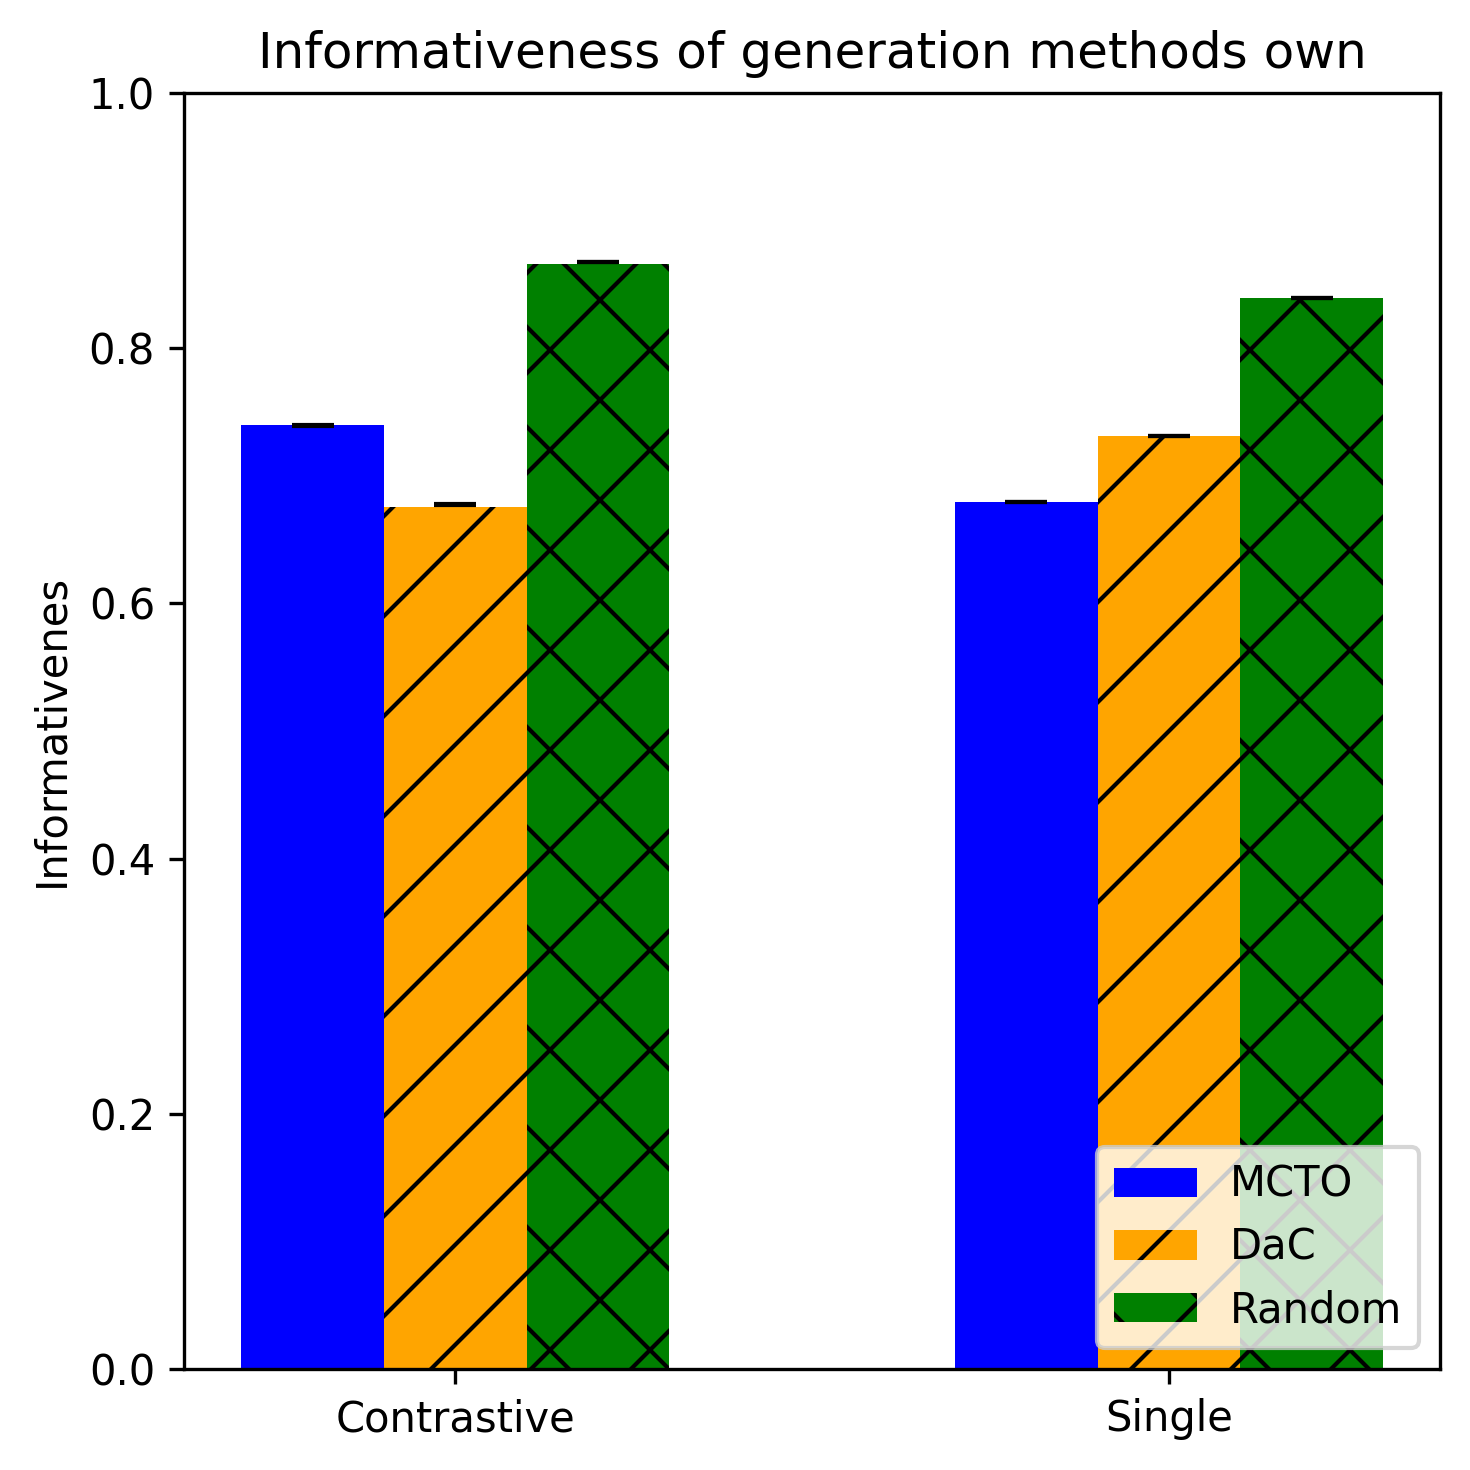

In [99]:
# plot the results
fig, ax1 = plt.subplots(figsize=(5, 5), dpi=300)
width = 0.2

mcts_means = [np.mean(pearson_correlations_own_con['mcts']), np.mean(pearson_correlations_own_sin['mcts'])]
mcts_medians = [np.median(pearson_correlations_own_con['mcts']), np.median(pearson_correlations_own_sin['mcts'])]
mcts_upper_quartile = [np.quantile(pearson_correlations_own_con['mcts'], 0.75), np.quantile(pearson_correlations_own_sin['mcts'], 0.75)]
mcts_lower_quartile = [np.quantile(pearson_correlations_own_con['mcts'], 0.25), np.quantile(pearson_correlations_own_sin['mcts'], 0.25)]

dac_means = [np.mean(pearson_correlations_own_con['dac']), np.mean(pearson_correlations_own_sin['dac'])]
dac_medians = [np.median(pearson_correlations_own_con['dac']), np.median(pearson_correlations_own_sin['dac'])]
dac_upper_quartile = [np.quantile(pearson_correlations_own_con['dac'], 0.75), np.quantile(pearson_correlations_own_sin['dac'], 0.75)]
dac_lower_quartile = [np.quantile(pearson_correlations_own_con['dac'], 0.25), np.quantile(pearson_correlations_own_sin['dac'], 0.25)]

random_means = [np.mean(pearson_correlations_own_con['random']), np.mean(pearson_correlations_own_sin['random'])]
random_medians = [np.median(pearson_correlations_own_con['random']), np.median(pearson_correlations_own_sin['random'])]
random_upper_quartile = [np.quantile(pearson_correlations_own_con['random'], 0.75), np.quantile(pearson_correlations_own_sin['random'], 0.75)]
random_lower_quartile = [np.quantile(pearson_correlations_own_con['random'], 0.25), np.quantile(pearson_correlations_own_sin['random'], 0.25)]

x_inf = np.arange(2)

rects1 = ax1.bar(np.array(x_inf) - width, mcts_means, width, color='b', label='MCTO', yerr=[np.subtract(mcts_means, mcts_lower_quartile), np.subtract(mcts_upper_quartile, mcts_means)], capsize=5)
rects2 = ax1.bar(x_inf, dac_means, width, label='DaC', color='orange', yerr=[np.subtract(dac_means, dac_lower_quartile), np.subtract(dac_upper_quartile, dac_means)], capsize=5, hatch='/')
rects3 = ax1.bar(np.array(x_inf) + width, random_means, width, label='Random', color='g', yerr=[np.subtract(random_means, random_lower_quartile), np.subtract(random_upper_quartile, random_means)], capsize=5, hatch='x')

ax1.set_ylabel('Informativenes', color='black')
ax1.set_title('Informativeness of generation methods own')
ax1.set_xticks(x_inf)  # We put the tick in the middle of the 3 'QC' bars
ax1.set_xticklabels(['Contrastive', 'Single'])
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1])
fig.tight_layout()

plt.savefig('informative_own_LM.pdf', format='pdf', dpi=300)

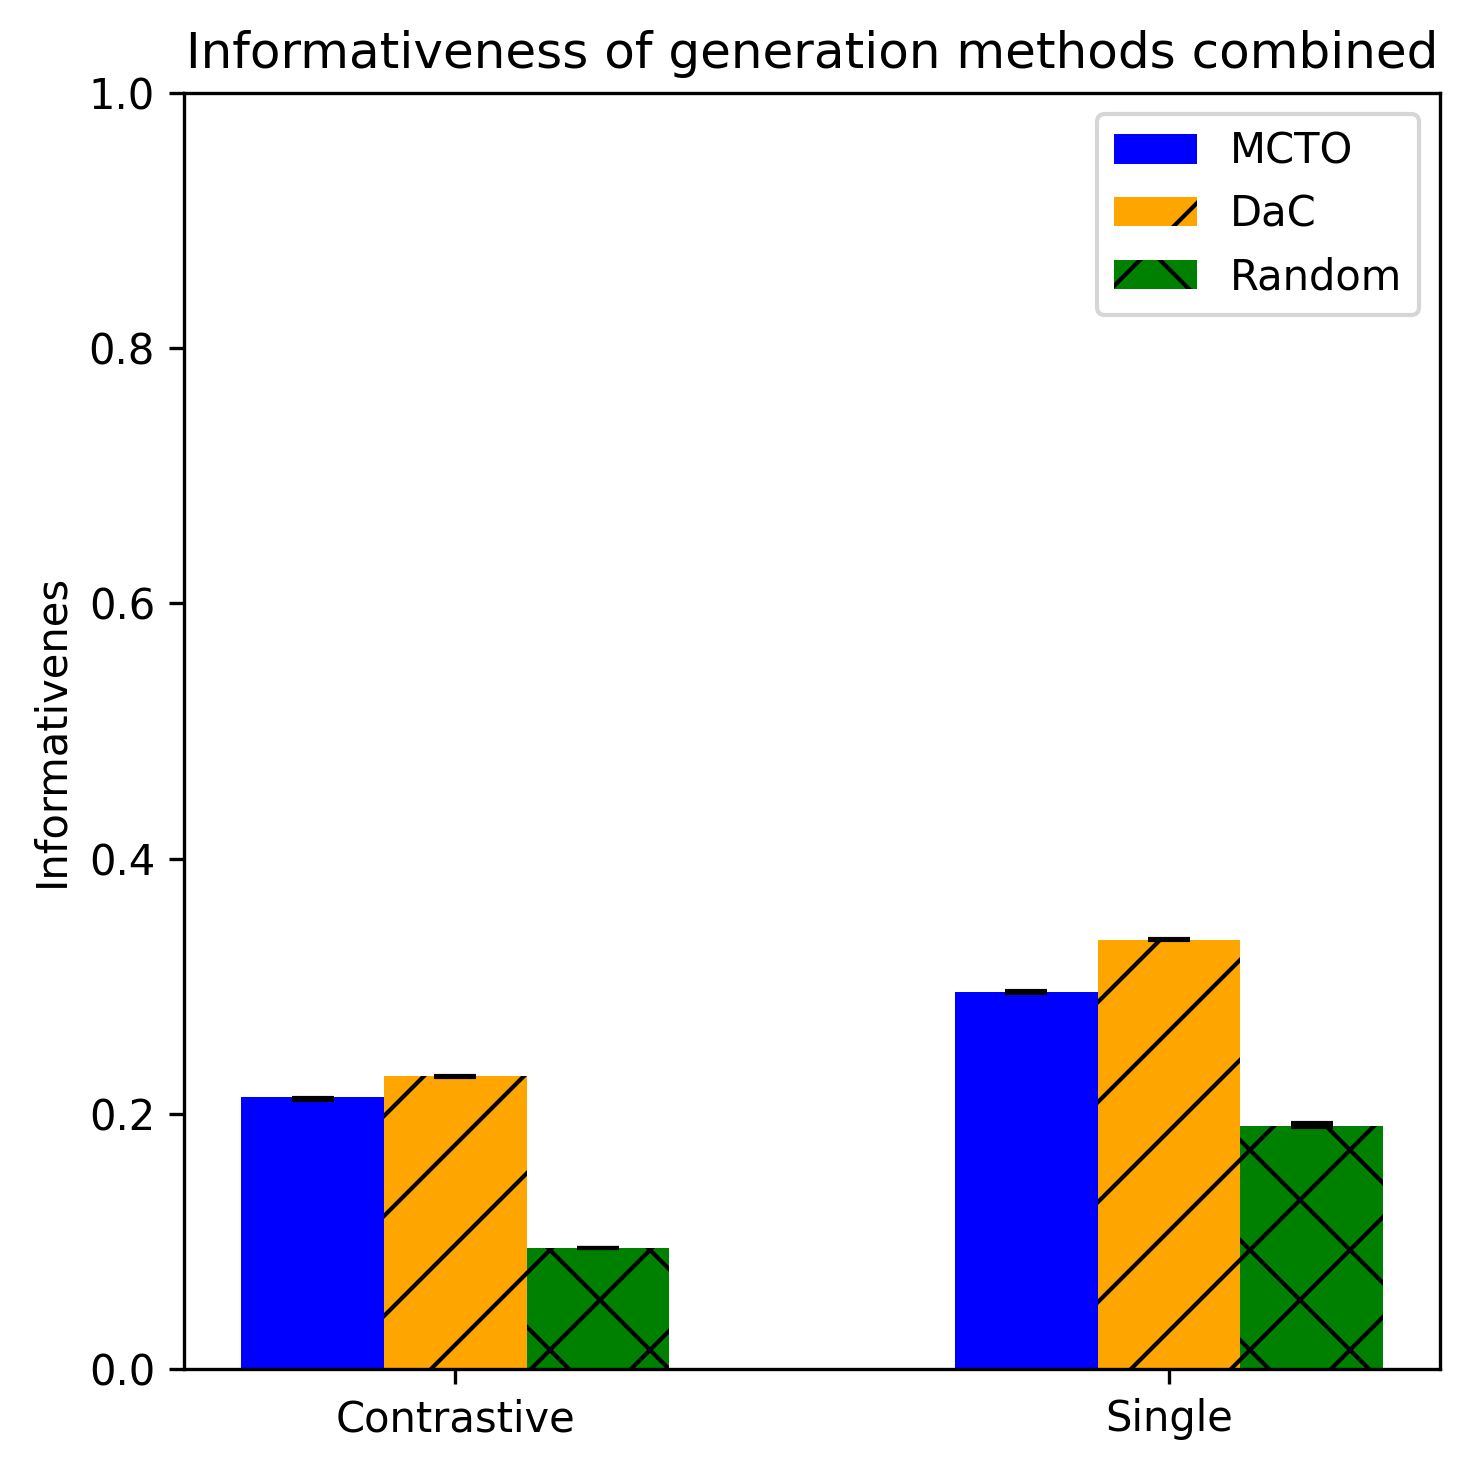

In [100]:
# plot the results
fig, ax1 = plt.subplots(figsize=(5, 5), dpi=300)
width = 0.2

mcts_means = [np.mean(pearson_correlations_combined_con['mcts']), np.mean(pearson_correlations_combined_sin['mcts'])]
mcts_medians = [np.median(pearson_correlations_combined_con['mcts']), np.median(pearson_correlations_combined_sin['mcts'])]
mcts_upper_quartile = [np.quantile(pearson_correlations_combined_con['mcts'], 0.75), np.quantile(pearson_correlations_combined_sin['mcts'], 0.75)]
mcts_lower_quartile = [np.quantile(pearson_correlations_combined_con['mcts'], 0.25), np.quantile(pearson_correlations_combined_sin['mcts'], 0.25)]

dac_means = [np.mean(pearson_correlations_combined_con['dac']), np.mean(pearson_correlations_combined_sin['dac'])]
dac_medians = [np.median(pearson_correlations_combined_con['dac']), np.median(pearson_correlations_combined_sin['dac'])]
dac_upper_quartile = [np.quantile(pearson_correlations_combined_con['dac'], 0.75), np.quantile(pearson_correlations_combined_sin['dac'], 0.75)]
dac_lower_quartile = [np.quantile(pearson_correlations_combined_con['dac'], 0.25), np.quantile(pearson_correlations_combined_sin['dac'], 0.25)]

random_means = [np.mean(pearson_correlations_combined_con['random']), np.mean(pearson_correlations_combined_sin['random'])]
random_medians = [np.median(pearson_correlations_combined_con['random']), np.median(pearson_correlations_combined_sin['random'])]
random_upper_quartile = [np.quantile(pearson_correlations_combined_con['random'], 0.75), np.quantile(pearson_correlations_combined_sin['random'], 0.75)]
random_lower_quartile = [np.quantile(pearson_correlations_combined_con['random'], 0.25), np.quantile(pearson_correlations_combined_sin['random'], 0.25)]

x_inf = np.arange(2)

rects1 = ax1.bar(np.array(x_inf) - width, mcts_means, width, color='b', label='MCTO', yerr=[np.subtract(mcts_means, mcts_lower_quartile), np.subtract(mcts_upper_quartile, mcts_means)], capsize=5)
rects2 = ax1.bar(x_inf, dac_means, width, label='DaC', color='orange', yerr=[np.subtract(dac_means, dac_lower_quartile), np.subtract(dac_upper_quartile, dac_means)], capsize=5, hatch='/')
rects3 = ax1.bar(np.array(x_inf) + width, random_means, width, label='Random', color='g', yerr=[np.subtract(random_means, random_lower_quartile), np.subtract(random_upper_quartile, random_means)], capsize=5, hatch='x')

ax1.set_ylabel('Informativenes', color='black')
ax1.set_title('Informativeness of generation methods combined')
ax1.set_xticks(x_inf)  # We put the tick in the middle of the 3 'QC' bars
ax1.set_xticklabels(['Contrastive', 'Single'])
ax1.legend(loc='upper right')
ax1.set_ylim([0, 1])
fig.tight_layout()
# plt.show()
plt.savefig('informative_combined_LM.pdf', format='pdf', dpi=300)